# Preparing data for eeg-ica-annotation Tool


* Preprocess the data
* Apply ICA
* Use Django API to save the data to the tool's db

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
%matplotlib notebook

mne.io includes the funtions for different EEG-record formats

Optional To Do
File formats (EDF, FIFF)

In [3]:
!wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf"

--2020-10-25 17:48:01--  https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2596896 (2.5M) [application/octet-stream]
Saving to: ‘S003R03.edf.2’

S003R03.edf.2       100%[===================>]   2.48M   821KB/s    in 3.1s    

2020-10-25 17:48:06 (821 KB/s) - ‘S003R03.edf.2’ saved [2596896/2596896]



In [4]:
!wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf.event"

--2020-10-25 17:48:06--  https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf.event
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638 [text/plain]
Saving to: ‘S003R03.edf.event.1’

S003R03.edf.event.1 100%[===================>]     638  --.-KB/s    in 0s      

2020-10-25 17:48:07 (40.6 MB/s) - ‘S003R03.edf.event.1’ saved [638/638]



In [3]:
sample = mne.io.read_raw_edf('S003R03.edf', verbose=False, preload=True)

Get some info about a record

In [4]:
sample.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [5]:
# Sampling frequency
sample.info['sfreq']

160.0

In [6]:
# Length in seconds
len(sample) / sample.info['sfreq']

125.0

In [7]:
# Number of channels
len(sample.ch_names)

64

## Channel selection and adding a montage

In [8]:
sample.ch_names[:3]

['Fc5.', 'Fc3.', 'Fc1.']

In [9]:
ch_map = {ch: ch.strip('.') for ch in sample.ch_names}
sample.rename_channels(ch_map)

<RawEDF | S003R03.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

In [10]:
sample.ch_names[:3]

['Fc5', 'Fc3', 'Fc1']

In [11]:
# 19 channels from 10-20. no A1 and A2 here
# Be careful. Pure 10-20 labeling differs from high-resolution montages
# In MNE, 10-20 montage is actually an extended high-resulution version of 10-20
# FYI, mapping from pure 10-20 to high-resolution versions
# T3 = T7
# T4 = T8
# T5 = P7
# T6 = P8

channels_to_use = [
    # prefrontal
    'Fp1',
    'Fp2',
    # frontal
    'F7',
    'F3',
    'F4',
    'Fz',
    'F8',
    # central and temporal
    'T7',
    'C3',
    'Cz',
    'C4',
    'T8',
    # parietal
    'P7',
    'P3',
    'Pz',
    'P4',
    'P8',
    # occipital
    'O1',
    'O2',
]

In [12]:
sample_1020 = sample.copy().pick_channels(channels_to_use)

# check that everything is OK
assert len(channels_to_use) == len(sample_1020.ch_names)

In [13]:
ch_map = {ch.lower(): ch for ch in sample_1020.ch_names}

In [14]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
len(ten_twenty_montage.ch_names)

94

In [15]:
ten_twenty_montage.ch_names = [ch_map[ch.lower()] if ch.lower() in ch_map else ch 
                               for ch in ten_twenty_montage.ch_names]

In [16]:
sample_1020.set_montage(ten_twenty_montage)

<RawEDF | S003R03.edf, 19 x 20000 (125.0 s), ~3.0 MB, data loaded>

### Band-pass filtering

It's better to remove low-freq components < 1 Hz and high-freq > 50Hz (non-informative for EEG)

Let's use 4-th order Butterworth filter (default IIR filter)

In [18]:
sample_1020.filter(l_freq=1, h_freq=50, method='iir')

<RawEDF | S003R03.edf, 19 x 20000 (125.0 s), ~3.0 MB, data loaded>

### Average referencing

In [19]:
sample_1020 = mne.set_eeg_reference(sample_1020, 'average')[0]

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<IPython.core.display.Javascript object>


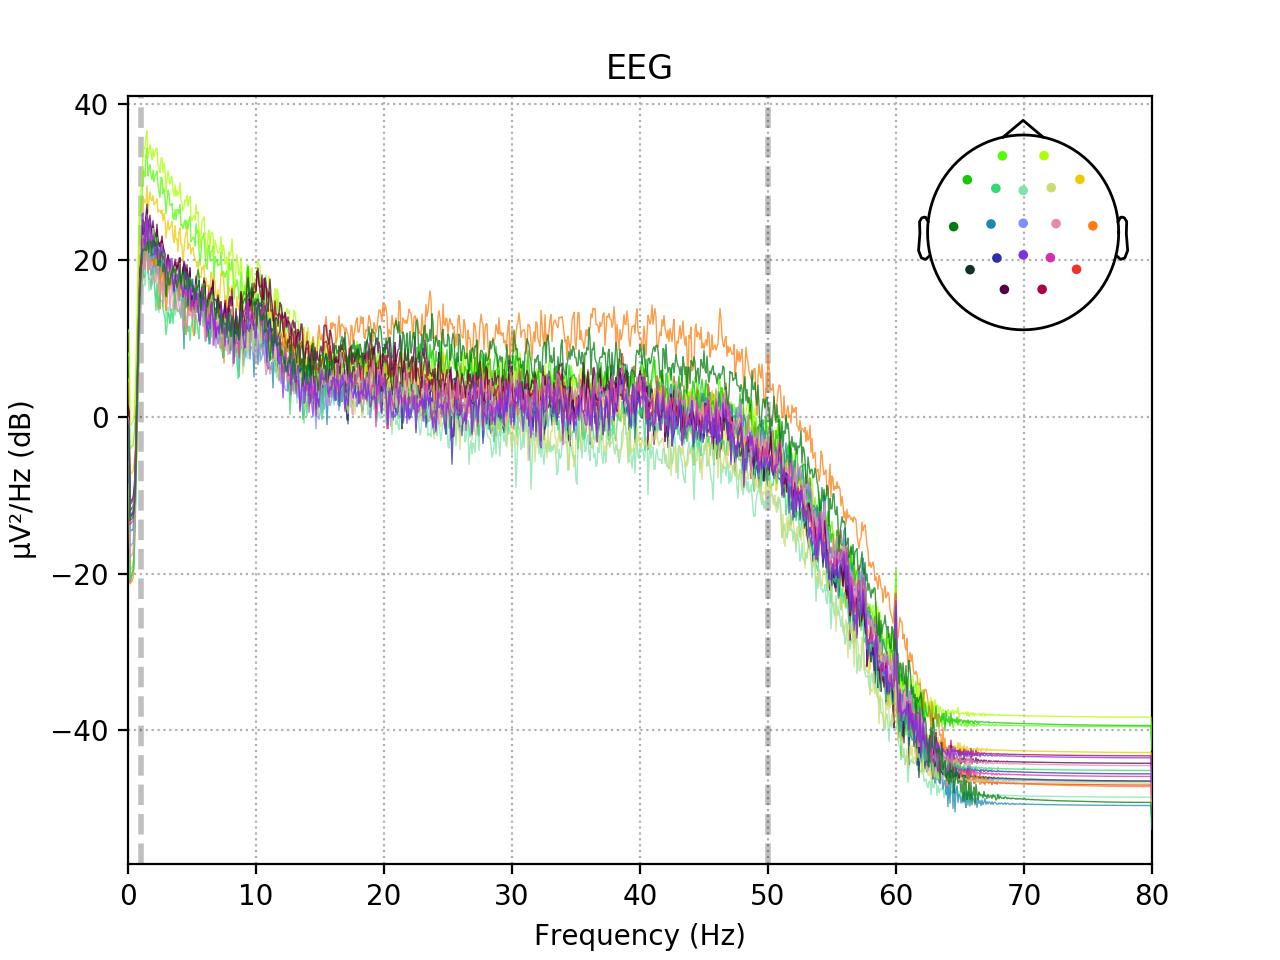

In [24]:
# Plot psd after filtering

# YOUR CODE HERE

sample_1020.plot_psd();

### Plot EEG signals

<IPython.core.display.Javascript object>


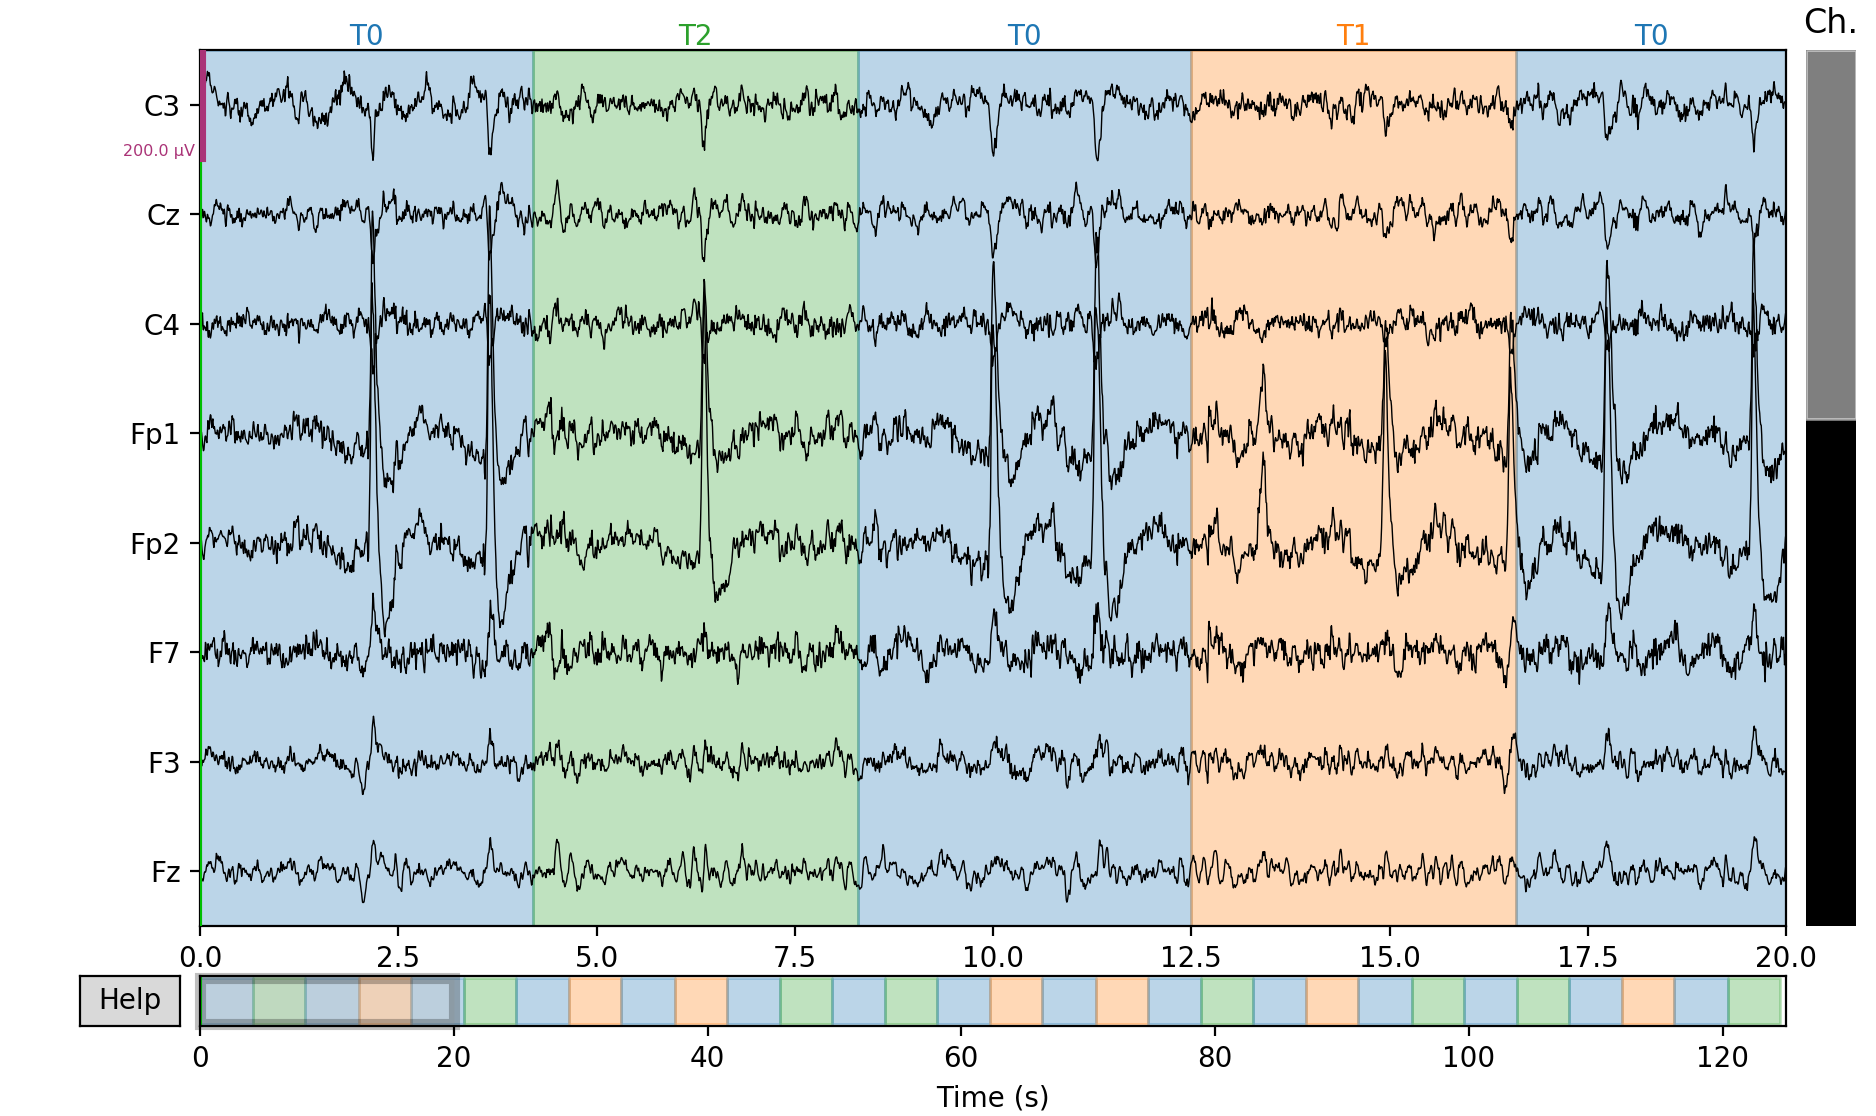

In [25]:
# Plot in better scale. Use 'scaling' argument

# Your code here

sample_1020.plot(n_channels=8, scalings={'eeg':1e-4}, duration=20);

## Extracting events

Mne has several functions for event selection. 

* `mne.find_events` is used when events are stored in trigger channels (e.g. FIFF format)
* `mne.events_from_annotations` is used for when events are stored in annotations (EDF+ format)
    
Look for documentation for your EEG-record format

Here we have EDF+ format

In [26]:
events, events_dict = mne.events_from_annotations(sample_1020)

epochs = mne.Epochs(sample_1020, events,  tmin=-0.5, tmax=0.8, reject={'eeg': 600e-6}, preload=True, baseline=(-.1, 0))

Used Annotations descriptions: ['T0', 'T1', 'T2']


PSD on epochs differs from the raw. More averaging is used

## Independent Component Analysis for Artifact Removal

In [53]:
n_components = 15

ica_epochs = mne.preprocessing.ICA(n_components=n_components, random_state=42)
ica_epochs.fit(epochs)
ica_src = ica_epochs.get_sources(sample_1020)

channels_to_use = [ch.lower() for ch in ica_epochs.info['ch_names']]

ica_src_df = ica_epochs.get_sources(epochs).to_data_frame()

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Fitting ICA took 0.1s.


In [38]:
import requests

In [60]:
url = 'http://127.0.0.1:8000/api/ica'

data_base = {
    "subject": "S1",
    "dataset": "my_dataset",
    "sfreq": 160.0,
}

In [51]:
a = 1
f"{a:03.0f}"

'001'

In [66]:
for ic_idx in range(n_components):
    df_weights = pd.DataFrame({'ch_name': channels_to_use, 
                               'value': ica_epochs.get_components()[:, ic_idx]})
    
    col_name = f'ICA{ic_idx:03.0f}'
    df_data = ica_src_df[['epoch', col_name]].rename(columns={col_name: 'value'})
    
    data = data_base.copy()
    data.update({
        "name": f"IC{ic_idx}",
        "ica_weights": df_weights.to_dict(orient='list'),
        "ica_data": df_data.to_dict(orient='list')
    })
    
    r = requests.post(url, json=data)
    
    assert (r.status_code == 201)    